In [57]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt

In [58]:
path_sn = "data_files/sn_data.txt"
path_kp = "data_files/kp_data.txt"

data_sn = pd.read_csv(path_sn)
data_kp = pd.read_csv(path_kp)
data_sn["date"] = pd.to_datetime(data_sn["date"])
data_kp["datetime"] = pd.to_datetime(data_kp["datetime"])
data_kp["date"] = data_kp["datetime"].dt.floor("d")
data_kp = data_kp.drop(columns=["datetime"])
# Sunspot number is counted daily. Kp is measured every three hours.
# Thus, to have the same frequency of both, we take the maximum Kp
# for each day, so that there is only one Kp measurement a day.
data_kp = data_kp.groupby(data_kp["date"]).max().reset_index()
data_merged = data_kp.merge(data_sn)
# Turn Kp index into binary variable
data_merged["Kp"] = (data_merged["Kp"] >= 5).astype("int")
data_merged_arr = data_merged.loc[:, ["SN", "Kp"]].values

In [59]:
# Commented out data scaling because it somehow seems that the scaling makes the model worse?
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = data_merged_arr#scaler.fit_transform(data_merged_arr)

In [60]:
def create_dataset(data_arr, lookback):
    """Create a dataset with input features, X and target feature y.
    
    The input and target features are generated by taking data from the data_arr in chunks
    of size lookback. If lookback is 7, then each element in X and y will be a week's worth of data.
    The input features and target features are shifted wrt each other by one. So for example, for
    lookback=7, the first element of X will be data_arr[0:7] and for y it will be data_arr[1:8]
    and so on.
    
    Of course, in the above examples, we are only really interested in data_arr[8] as our
    target. The reason we make the target overlapping with X is because some guy on a blogpost claimed
    it was better to do it like this.
    """
    X, y = [], []
    for i in range(len(data_arr)-lookback):
        feature = data_arr[i:i+lookback]
        target = data_arr[i+1:i+lookback+1, -1]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(-1)

In [61]:
lookback = 7
train_frac = 0.9
train_size = int(len(data_scaled) * train_frac)
train = data_scaled[:train_size]
test = data_scaled[train_size:]

In [62]:
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([4597, 7, 2]) torch.Size([4597, 7, 1])
torch.Size([505, 7, 2]) torch.Size([505, 7, 1])


In [63]:
class SunModelLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers): 
        super(SunModelLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [64]:
input_size = 2
hidden_size = 50
num_layers = 5
batch_size = 32

In [65]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [66]:
def train_valid(n_epochs, model, optimizer, loss_fn, train_loader, test_loader, device):
    train_hist = []
    test_hist = []

    # Training loop
    for epoch in range(n_epochs):
        total_loss = 0.0
    
        # Training
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_y)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
        # Calculate average training loss and accuracy
        average_loss = total_loss / len(train_loader)
        train_hist.append(average_loss)
    
        # Validation on test data
        model.eval()
        with torch.no_grad():
            total_test_loss = 0.0
    
            for batch_X_test, batch_y_test in test_loader:
                batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                predictions_test = model(batch_X_test)
                test_loss = loss_fn(predictions_test, batch_y_test)
    
                total_test_loss += test_loss.item()
    
            # Calculate average test loss and accuracy
            average_test_loss = total_test_loss / len(test_loader)
            test_hist.append(average_test_loss)
        if (epoch+1)%10==0:
            print(f'Epoch [{epoch+1}/{n_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')
    return train_hist, test_hist    

In [67]:
n_epochs = 50
loss_fn = nn.BCELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SunModelLSTM(input_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters())
model.to(device)

SunModelLSTM(
  (lstm): LSTM(2, 50, num_layers=5, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [68]:
train_hist, test_hist = train_valid(n_epochs, model, optimizer, loss_fn, train_loader, test_loader, device)

Epoch [10/50] - Training Loss: 0.2529, Test Loss: 0.3645
Epoch [20/50] - Training Loss: 0.2512, Test Loss: 0.3645
Epoch [30/50] - Training Loss: 0.2512, Test Loss: 0.3659
Epoch [40/50] - Training Loss: 0.2511, Test Loss: 0.3653
Epoch [50/50] - Training Loss: 0.2510, Test Loss: 0.3636


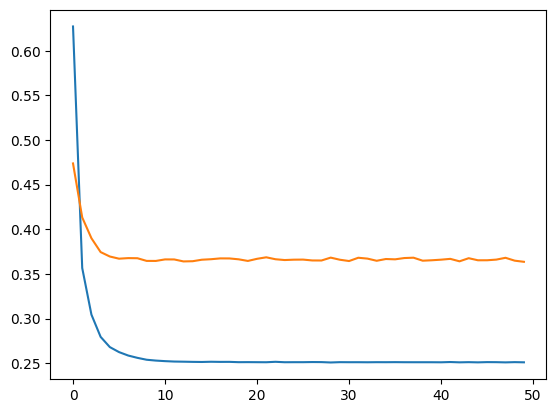

In [69]:
plt.plot(train_hist)
plt.plot(test_hist)

In [70]:
def make_pred1(X_test, week_number, num_forecast_steps, lookback):
    sequence_to_plot = X_test.squeeze().cpu().numpy()
    # Predict based on the first chunk (week for lookback=7) in the test set
    historical_data = sequence_to_plot[week_number]
    forecasted_values = []
    with torch.no_grad():
        for _ in range(num_forecast_steps+lookback):
            historical_data_tensor = torch.as_tensor(historical_data).float().to(device)
            predicted_value = model(historical_data_tensor).cpu().numpy()[0]
            forecasted_values.append(predicted_value[0])

            historical_data = np.roll(historical_data, shift=-1)
            historical_data[-1] = predicted_value
    return forecasted_values

In [71]:
num_forecast_steps = 14
week_number = 27
forecasted_vals = make_pred1(X_test, week_number, num_forecast_steps, lookback)
# forecasted_vals = scaler.inverse_transform(np.stack((np.arange(len(forecasted_vals)), forecasted_vals)).T)[:, 1]
true_data = test[week_number][lookback:]
# true_data = scaler.inverse_transform(true_data)[:, 1]

In [72]:
(np.array(forecasted_vals[lookback:]).reshape(-1)) 

array([0.38521287, 0.07085598, 0.3848736 , 0.07085554, 0.38270593,
       0.07085373, 0.0725285 , 0.0720291 , 0.07252682, 0.07203043,
       0.07252256, 0.07203385, 0.07251697, 0.07203833], dtype=float32)

In [82]:
X_test[30]

tensor([[110.,   0.],
        [ 86.,   0.],
        [ 85.,   0.],
        [ 79.,   0.],
        [ 76.,   0.],
        [ 80.,   0.],
        [ 72.,   0.]])